In [1]:
import pandas as pd
import numpy as np
import datetime as dt # for date data type
import seaborn as sns # For creating plots
import geopandas as gdp
import matplotlib.pyplot as plt
import plotly.express as px
import holoviews as hv
import datetime
import numexpr
from platform import python_version

import panel as pn

pn.extension()
pn.extension('plotly')

print(python_version())

/home/merlin/.local/lib/python3.8/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_4449/168731610.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (

3.8.13


In [2]:
df= pd.read_csv("df_clean.csv", parse_dates=['Toimumisaeg2']).set_index("Toimumisaeg2").sort_index()
df.head(5)

,Unnamed: 0,Juhtumi nr,Toimumisaeg,Isikuid,Hukkunuid,Vigastatuid,Sõidukeid,Aadress (PPA),Maja nr (PPA),Tänav (PPA),...,Tee nr (PPA),Tee km (PPA),Ilmastik [1],Valgustus [1],Valgustus [2],GPS X,GPS Y,Asukoht,lon,lat
Toimumisaeg2,,,,,,,,,,,,,,,,,,,,,
2011-01-05,2117,2490110002994,1/5/11,1.0,0,2,1.0,Jõgeva maakond VANA Põltsamaa vald,NaN,PIKKNURME - PÕLTSAMAA,...,14175.0,"9,2",Selged olud,Valge aeg,Valge aeg,6495324,621101,POINT (26.082246440862306 58.5809878216108),26.082246,58.580988
2011-01-08,455,2302110170106,1/8/11,2.0,0,1,2.0,Harju maakond Rae vald,NaN,TALLINN - TARTU - VÕRU - LUHAMAA,...,2.0,9,Selged olud,Valge aeg,Valge aeg,6582359,548106,POINT (24.846256904304 59.37649481762436),24.846257,59.376495
2011-01-08,2350,2502110056614,1/8/11,1.0,0,1,1.0,Pärnu maakond VANA Häädemeeste vald,NaN,IKLA - PIIRI,...,19348.0,1,Selged olud,Valge aeg,Valge aeg,6415281,522787,POINT (24.38404570760267 57.87861953982567),24.384046,57.878620
2011-01-11,645,2302110256946,1/11/11,4.0,0,2,4.0,Harju maakond Tallinn Kristiine linnaosa Sõpr...,NaN,Sõpruse pst,...,NaN,NaN,Pilvised olud,Pimeda aeg,Pimeda ajal valgustus põleb,6587100,540473,POINT (24.712878334859145 59.41984523631749),24.712878,59.419845
2011-01-11,644,2302110256697,1/11/11,2.0,1,0,3.0,Harju maakond Kiili vald,NaN,TALLINN - RAPLA - TÜRI,...,15.0,"5,3",Selged olud,Valge aeg,Valge aeg,6579784,543958,POINT (24.772772270384877 59.35383139613875),24.772772,59.353831


In [3]:
# Make suitable df for dashboard

df['year'] = df.index.year.astype('category')
df['month'] = df.index.month.astype('category')
df['day_of_week'] = df.index.day_name().astype('category')
df['hour_of_day'] = np.where(df.index.time != datetime.time(0, 0), df.index.hour.astype('category'), np.nan)


## Siia kogun nupud

In [4]:
min = pd.to_datetime(df.index.min())
max =pd.to_datetime(df.index.max())

# Slider kaardile aja perioodi muutmiseks
slider = pn.widgets.DateRangeSlider(
    name='Ajavahemik',
    start=min, end=max,
    value=(min, max),
    step=10000
)

#datetime_range_slider

In [7]:
# valikunupud perioodi joonistele

perioodid = pn.widgets.RadioButtonGroup(
    name='Periood', options=['Aastad', 'Kuud', 'Päevad', 'Tunnid'], button_type='default', orientation='vertical')

perioodid

RadioButtonGroup(name='Periood', options=['Aastad', 'Kuud', ...], orientation='vertical', value='Aastad')

In [5]:
# multiselect widget for participant type
# pole kasutusel

multi_choice = pn.widgets.MultiChoice(name='Liiklusõnnetuse osalised', value=[],
    options=['Jalakäija osalusel', 'Kergliikurijuhi osalusel', 'Kaassõitja osalusel', 'Maastikusõiduki juhi osalusel', "Eaka (65+) mootorsõidukijuhi osalusel",  "Bussijuhi osalusel", "Veoautojuhi osalusel", "Ühissõidukijuhi osalusel", "Sõiduautojuhi osalusel", "Mootorratturi osalusel", "Mopeedijuhi osalusel", "Jalgratturi osalusel", "Alaealise osalusel", "Turvavarustust mitte kasutanud isiku osalusel", "Esmase juhiloa omaniku osalusel", "Mootorsõidukijuhi osalusel"])

pn.Column(multi_choice, height=400)
#multi_choice

Column(height=400)
    [0] MultiChoice(name='Liiklusõnnetuse o..., options=['Jalakäija osalusel', ...])

In [ ]:
# suured numbrid - hukkunud, vigastatud ja õnnetusi
@pn.depends( pn.widgets.RadioButtonGroup.param.value)   
def statistika(slider_value):
    df_kaart=df.loc[pd.to_datetime(slider_value[0]):pd.to_datetime(slider_value[1])]    
    options=['Hukkunuid', 'Vigastatuid', 'Isikuid', 'Sõidukeid']

    # Count the number of accidents for each participant type
    df_sum = df_kaart[options].apply(pd.Series.sum).T.reset_index()


    # Create the plot using Plotly Express
    fig = px.bar(df_count, y='index', x=1.0, title='Õnnetuses osalejad')
    fig.update_layout(
    xaxis_title='Kokku',
    yaxis_title='')

    return fig

statistika(slider.value)

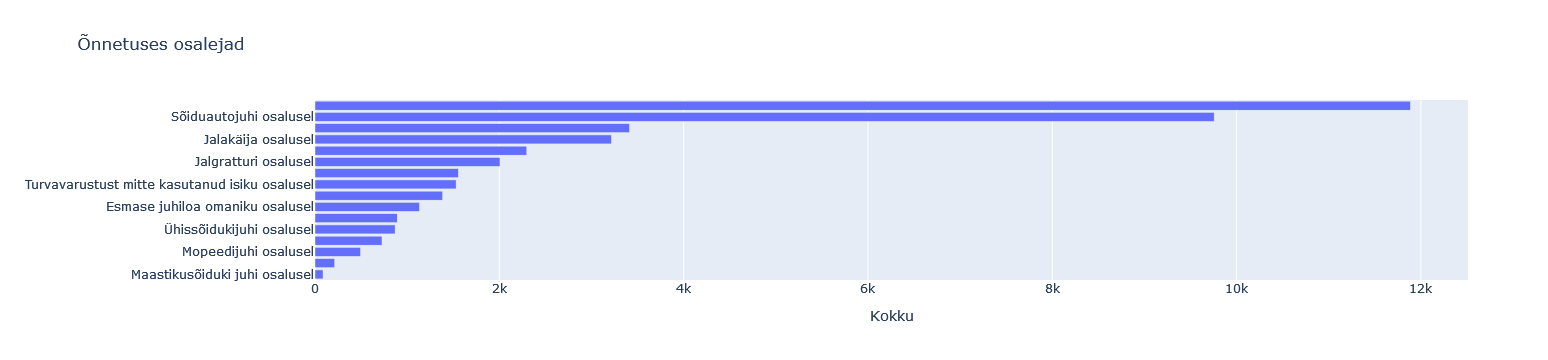

In [26]:
# liiklusõnnetused osaleja tüüpide kaupa
@pn.depends( pn.widgets.RadioButtonGroup.param.value)   
def osalejad(slider_value):
    df_kaart=df.loc[pd.to_datetime(slider_value[0]):pd.to_datetime(slider_value[1])]    
    options=['Jalakäija osalusel', 'Kergliikurijuhi osalusel', 'Kaassõitja osalusel', 'Maastikusõiduki juhi osalusel', "Eaka (65+) mootorsõidukijuhi osalusel",  "Bussijuhi osalusel", "Veoautojuhi osalusel", "Ühissõidukijuhi osalusel", "Sõiduautojuhi osalusel", "Mootorratturi osalusel", "Mopeedijuhi osalusel", "Jalgratturi osalusel", "Alaealise osalusel", "Turvavarustust mitte kasutanud isiku osalusel", "Esmase juhiloa omaniku osalusel", "Mootorsõidukijuhi osalusel"]

    # Count the number of accidents for each participant type
    df_count = df_kaart[options].apply(pd.Series.value_counts).T.reset_index().sort_values(1.0)


    # Create the plot using Plotly Express
    fig = px.bar(df_count, y='index', x=1.0, title='Õnnetuses osalejad')
    fig.update_layout(
    xaxis_title='Kokku',
    yaxis_title='')

    return fig

osalejad(slider.value)

In [8]:
perioodid.value



'Aastad'

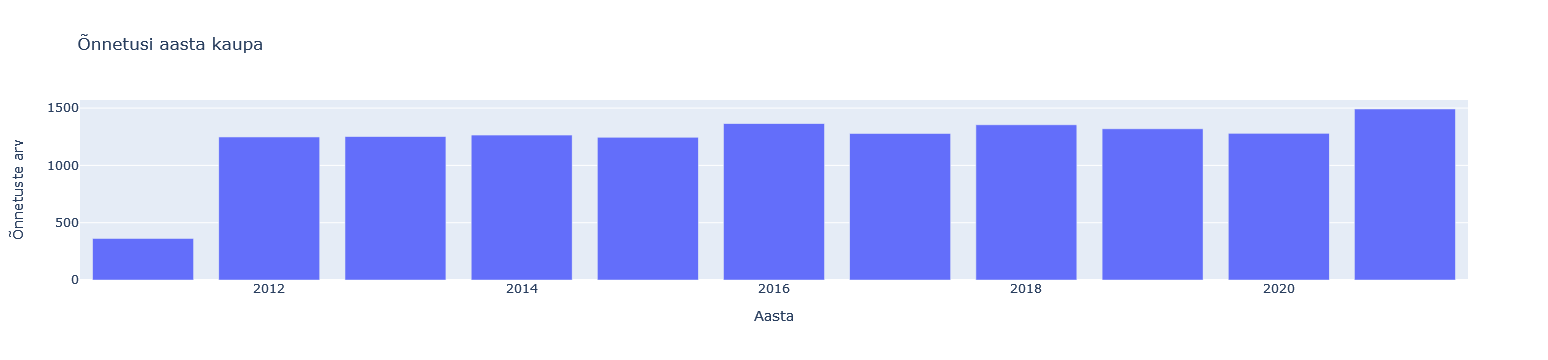

In [9]:
# Extracting year, month, day of week, and hour of day from the 'time_of_accident' column

#@pn.depends( pn.widgets.Button.param.button_type.objects)
@pn.depends( pn.widgets.RadioButtonGroup.param.value)
def perioodid_joonis(perioodid, slider_value):
    df_kaart=df.loc[pd.to_datetime(slider_value[0]):pd.to_datetime(slider_value[1])]
    
    # Counting the number of accidents for each time component
    Aastad = df_kaart['year'].value_counts().sort_index()
    Kuud = df_kaart['month'].value_counts().sort_index()
    Päevad = df_kaart['day_of_week'].value_counts().sort_index()
    Tunnid =df_kaart['hour_of_day'].value_counts().sort_index()

    # Creating bar plots using Plotly
    if perioodid == "Aastad":
        fig = px.bar(x=Aastad.index, y=Aastad.values, labels={'x': 'Aasta', 'y': 'Õnnetuste arv'}, title='Õnnetusi aasta kaupa')
    elif perioodid == "Kuud":
        fig = px.bar(x=Kuud.index, y=Kuud.values, labels={'x': 'Kuu','y': 'Õnnetuste arv'}, title='Õnnetusi kuude kaupa')
    elif perioodid == "Päevad":
        fig = px.bar(x=Päevad.index, y=Päevad.values, labels={'x': 'Nädalapäev','y': 'Õnnetuste arv'}, title='Õnnetusi päevade kaupa')
    elif perioodid == "Tunnid":
        fig = px.bar(x=Tunnid.index, y=Tunnid.values, labels={'x': 'Tund','y': 'Õnnetuste arv'}, title='Õnnetusi tundide kaupa')
    
    return fig

perioodid_joonis(perioodid.value, slider.value)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13459 entries, 2011-01-05 00:00:00 to 2021-12-31 23:45:00
Data columns (total 61 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Unnamed: 0                                     13459 non-null  int64   
 1   Juhtumi nr                                     13459 non-null  object  
 2   Toimumisaeg                                    13459 non-null  object  
 3   Isikuid                                        13384 non-null  float64 
 4   Hukkunuid                                      13459 non-null  int64   
 5   Vigastatuid                                    13459 non-null  int64   
 6   Sõidukeid                                      13384 non-null  float64 
 7   Aadress (PPA)                                  13381 non-null  object  
 8   Maja nr (PPA)                                  6271 non-null   object  
 9   Täna

In [11]:
@pn.depends( pn.widgets.DateRangeSlider.param.value_throttled)
def kaart(slider_value):
    df_kaart=df.loc[pd.to_datetime(slider_value[0]):pd.to_datetime(slider_value[1])]
    fig = px.scatter_mapbox(df_kaart, lat ="lat", lon="lon", height=600, zoom=6.5)
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    #fig.show()
    
    return fig
#kaart(lider.value)

In [12]:
# Function to display current year
@pn.depends( pn.widgets.DateRangeSlider.param.value_throttled)
def tiitel(slider):
    return '### Liiklusõnnetuste statistika ajavahemikul '

In [27]:
dashboard = pn.WidgetBox(pn.Row(
                             pn.Column(
                                 pn.Row(tiitel, slider),
                                 pn.Row(pn.bind(kaart, slider)),
                                 pn.Row(perioodid, pn.bind(perioodid_joonis, perioodid, slider)), align="start",          
                                 sizing_mode="stretch_width"), 
                             pn.Column(pn.Row(pn.bind(osalejad, slider)))))
dashboard

WidgetBox
    [0] Row
        [0] Column(sizing_mode='stretch_width')
            [0] Row
                [0] ParamFunction(function)
                [1] DateRangeSlider(end=Timestamp('2021-12-31 2..., name='Ajavahemik', start=Timestamp('2011-01-05 0..., step=10000, value=(Timestamp('2011-01-05 00:..., value_end=Timestamp('2021-12-31 2..., value_start=Timestamp('2011-01-05 0...)
            [1] Row
                [0] ParamFunction(function)
            [2] Row
                [0] RadioButtonGroup(name='Periood', options=['Aastad', 'Kuud', ...], orientation='vertical', value='Aastad')
                [1] ParamFunction(function)
        [1] Column
            [0] Row
                [0] ParamFunction(function)

https://towardsdatascience.com/using-panel-and-hvplot-to-visualize-decades-of-wildfires-2ac8d6f5db25
https://hvplot.holoviz.org/user_guide/Widgets.html
https://panel.holoviz.org/reference/widgets/DatetimeRangeSlider.html